# Introdução

O método Diferença-em-Diferenças (DiD) é uma técnica estatística utilizada em econometria e pesquisa social para estimar o efeito causal de uma intervenção, tratamento ou política, comparando as mudanças ao longo do tempo entre um grupo de tratamento que recebe a intervenção e um grupo de controle que não a recebe. Essencialmente, o DiD compara a diferença nas médias entre os dois grupos antes e depois da intervenção.

# Passos para Aplicação


A seguir estão os **passos para aplicar o método de Diferença-em-Diferenças (DiD)**.

### 1. **Definir a política/intervenção e os grupos**

* Identifique **quem foi exposto** à política/intervenção (**grupo tratado**) e **quem não foi** (**grupo controle**).
* Determine o **momento exato da intervenção** para distinguir períodos **antes** e **depois**.

### 2. **Coletar ou organizar os dados**

* Dados em **painel** (indivíduos ao longo do tempo) ou dados agregados por grupo/período.
* Variável de interesse $Y$: o desfecho que se quer estudar (ex: nota, salário, taxa de criminalidade etc.).
* Codificar:

  * `tratado` = 1 para unidades tratadas, 0 para controle.
  * `depois` = 1 para o período após a intervenção, 0 para antes.
  * `interacao = tratado × depois`: captura o efeito DiD.

### 3. **Explorar graficamente os dados**

* Plote a média de $Y$ por grupo ao longo do tempo.
* Verifique se os grupos têm **tendências semelhantes antes da intervenção** → isso sustenta a **hipótese de tendências paralelas**.

### 4. **Especificar e estimar o modelo DiD**

* Modelo linear básico:

$$
y_i = \beta_0 + \beta_1 \cdot \text{Depois}_i + \beta_2 \cdot \text{Tratado}_i + \beta_3 \cdot (\text{Tratado}_i \times \text{Depois}_i) + \varepsilon_i
$$

  * $\beta_3$ é o **efeito causal estimado** da intervenção.
* Estime com regressão linear (OLS), usando pacotes como `statsmodels`, `R lm()` ou `Stata reg`.

### 5. **Interpretar os coeficientes**

* $\beta$: quanto a intervenção alterou o valor médio de $Y$, **corrigido por tendências gerais e diferenças prévias**.

### 6. **Verificar robustez e validade**

* Testes de placebo (ex: aplicar DiD em períodos antes da intervenção).
* Testes com covariáveis adicionais.
* Eventualmente, usar um **event study** para verificar o comportamento pré e pós intervenção com mais nuance.

### 7. **Concluir sobre o efeito causal**

* Se a hipótese de tendências paralelas for plausível, o $\beta$ pode ser interpretado como um **efeito causal médio do tratamento**.

# Exemplo 1

> Uma prefeitura implementou um **programa de alimentação escolar** com o objetivo de melhorar o desempenho de estudantes da rede pública. Esse programa foi oferecido a um **grupo selecionado de escolas (grupo tratado)**, enquanto outras escolas não participaram (grupo controle). Queremos avaliar o efeito da alimentação escolar sobre o desempenho em um teste padronizado.
O programa é implementado em determinadas escolas a partir de certo ano.
Os testes são aplicados a diferentes coortes de alunos a cada ano.
Cada aluno faz o teste apenas uma vez.

Os dados a seguir foram coletados:

<center>

| Nome     | y   | Tratado | Depois |
| -------- | --- | ------- | ------ |
| Miguel   | 40  | 0       | 0      |
| Júlia    | 80  | 1       | 1      |
| Davi     | 20  | 0       | 0      |
| Sophia   | 100 | 1       | 1      |
| Gabriel  | 30  | 0       | 0      |
| Isabella | 0   | 1       | 0      |
| Arthur   | 60  | 0       | 1      |
| Manuela  | 40  | 1       | 0      |
| Lucas    | 60  | 0       | 1      |
| Giovana  | 90  | 0       | 1      |

</center>

* A coluna `Tratado` indica se o aluno participou do programa (1 = sim, 0 = não).
* A coluna `Depois` indica se a pontuação foi registrada **após** a implementação do programa (1 = depois, 0 = antes).
* A variável `y` representa a pontuação obtida pelo aluno na avaliação padronizada.

> **Pergunta de pesquisa:** O programa de alimentação escolar teve efeito causal sobre o desempenho dos alunos?


## **Passo 1: Definir a política/intervenção e os grupos**

### Interpretação das variáveis:

* `Tratado = 1`: indivíduos que **foram expostos à intervenção** (grupo tratado). Ex: Júlia, Sophia, Isabella, Manuela.
* `Tratado = 0`: indivíduos **não expostos à intervenção** (grupo controle). Ex: Miguel, Davi, Gabriel, Arthur, Lucas, Giovana.
* `Depois = 1`: observações no período **pós-intervenção**.
* `Depois = 0`: observações no período **pré-intervenção**.

Com isso, temos um desenho do tipo:

|              | **Antes** (`Depois=0`) | **Depois** (`Depois=1`) |
| ------------ | ---------------------- | ----------------------- |
| **Controle** | Miguel, Davi, Gabriel  | Arthur, Lucas, Giovana  |
| **Tratado**  | Isabella, Manuela      | Júlia, Sophia           |

## **Passo 2: Coletar ou organizar os dados**

Objetivo: Estruturar os dados de forma que possamos aplicar corretamente o modelo de Diferença-em-Diferenças.

Os dados já estão no formato "long" (cada linha = uma unidade observada em um momento), o que é apropriado para aplicação do método.

Já temos:

* Variável de desfecho: `y`
* Indicador de tratamento: `Tratado`
* Indicador de tempo: `Depois`
* Variável de interação (vamos criar no passo 4)

In [10]:
import pandas as pd
import statsmodels.api as sm

# Criando um DataFrame com os dados
data = {'Name': ['Miguel', 'Júlia', 'Davi', 'Sophia', 'Gabriel', 'Isabella', 'Arthur', 'Manuela', 'Lucas', 'Giovana'],
        'y': [40, 80, 20, 100, 30, 0, 60, 40, 60, 90],
        'Tratado': [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        'Depois': [0, 1, 0, 1, 0, 0, 1, 0, 1, 1]}

df = pd.DataFrame(data)
df.head(10)

,Name,y,Tratado,Depois
0,Miguel,40,0,0
1,Júlia,80,1,1
2,Davi,20,0,0
3,Sophia,100,1,1
4,Gabriel,30,0,0
5,Isabella,0,1,0
6,Arthur,60,0,1
7,Manuela,40,1,0
8,Lucas,60,0,1
9,Giovana,90,0,1


## **Passo 3: Explorar graficamente os dados**

Objetivo: Investigar se as **tendências entre os grupos eram semelhantes antes da intervenção**, ou seja, verificar a plausibilidade da **hipótese de tendências paralelas**.

Como temos apenas um período "antes" e um "depois", faremos uma **visualização das médias** da variável `y` para os grupos tratado e controle em cada período.

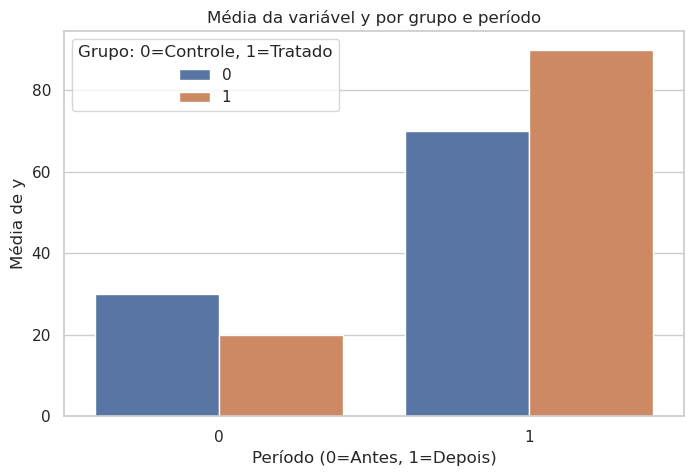

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de barras com média de y por grupo e tempo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Depois', y='y', hue='Tratado', errorbar=None)
plt.title("Média da variável y por grupo e período")
plt.xlabel("Período (0=Antes, 1=Depois)")
plt.ylabel("Média de y")
plt.legend(title="Grupo: 0=Controle, 1=Tratado")
plt.show()

In [13]:
# Alternativamente, podemos inspecionar as médias numéricas:

df.groupby(['Tratado', 'Depois'])['y'].mean().unstack()

Depois,0,1
Tratado,,
0,30.0,70.0
1,20.0,90.0


### Interpretação esperada:

Você verá quatro médias:

* **Controle antes** (Miguel, Davi, Gabriel): média de y ≈ (40 + 20 + 30)/3 = 30
* **Controle depois** (Lucas, Giovana): média de y ≈ (60 + 90)/2 = 75
* **Tratado antes** (Isabella, Manuela): média de y = (0 + 40)/2 = 20
* **Tratado depois** (Júlia, Sophia): média de y = (80 + 100)/2 = 90

Mesmo com dados pequenos, parece haver um padrão:

* Ambos os grupos melhoraram após a intervenção.
* O grupo tratado melhorou **mais fortemente**.

No entanto, com apenas um ponto antes da intervenção, **não é possível verificar tendências paralelas diretamente** — isso é uma limitação importante.

## **Passo 4: Especificar e estimar o modelo DiD via regressão**

Objetivo: Estimar o efeito causal da intervenção sobre a variável `y` usando um **modelo de regressão com interação**.

### Modelo matemático:

O modelo padrão de Diferença-em-Diferenças com dois grupos (controle/tratado) e dois períodos (antes/depois) é:

$$
y_i = \beta_0 + \beta_1 \cdot \text{Depois}_i + \beta_2 \cdot \text{Tratado}_i + \beta_3 \cdot (\text{Tratado}_i \times \text{Depois}_i) + \varepsilon_i
$$

* $\beta_0$: média do grupo controle antes da intervenção.
* $\beta_1$: diferença média entre tratado e controle **antes**.
* $\beta_2$: variação do grupo controle ao longo do tempo.
* $\beta_3$: **efeito causal estimado da intervenção** (Diferença-em-Diferenças).

### Etapas em código:

1. Criar a variável de interação:

```python
        df['interacao'] = df['Tratado'] * df['Depois']
```

2. Estimar o modelo com `statsmodels`:

```python
        import statsmodels.api as sm

        X = df[['Tratado', 'Depois', 'interacao']]
        X = sm.add_constant(X)
        y = df['y']

        modelo = sm.OLS(y, X).fit()
        print(modelo.summary())
```

### Interpretação esperada dos coeficientes:

| Termo       | Interpretação                                       |
| ----------- | --------------------------------------------------- |
| `const`     | Média do grupo controle antes da intervenção        |
| `Tratado`   | Diferença entre grupo tratado e controle no **pré** |
| `Depois`    | Diferença temporal no grupo controle (pré → pós)    |
| `interacao` | **Estimativa do efeito causal da política (DiD)**   |


In [14]:
df['interacao'] = df['Tratado'] * df['Depois']
X = df[['Tratado', 'Depois', 'interacao']]
X = sm.add_constant(X)
y = df['y']
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     8.178
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0153
Time:                        11:56:05   Log-Likelihood:                -40.154
No. Observations:                  10   AIC:                             88.31
Df Residuals:                       6   BIC:                             89.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0000     10.000      3.000      0.0

/home/ebezerra/anaconda3/envs/gcc1625/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


A seguir está a descrição do **significado de cada coeficiente** da regressão linear estimada no modelo de Diferença-em-Diferenças aplicado aos dados.

#### `const`

* **Valor esperado:** 30.0
* **O que representa:**
  A média da variável `y` (pontuação) para o **grupo controle** no **período anterior à intervenção**.
* **Por quê:**
  No modelo, esse é o valor da interceptação quando `Tratado = 0` e `Depois = 0`.

---

#### `Tratado`

* **Valor esperado:** -10.0
* **O que representa:**
  A **diferença média** de pontuação **entre o grupo tratado e o grupo controle antes da intervenção**.
* **Interpretação:**
  Antes da política, os alunos do grupo tratado tinham pontuação média **10 pontos menor** que os do grupo controle.
* **Importância:**
  Mede o viés de seleção inicial entre os grupos (antes do tratamento).

---

#### `Depois`

* **Valor esperado:** +40.0
* **O que representa:**
  A **mudança média na pontuação do grupo controle** entre o período antes e o depois da intervenção.
* **Interpretação:**
  Mesmo sem tratamento, os alunos do grupo controle melhoraram em média 40 pontos (ex: por maturidade, práticas escolares gerais etc.).
* **Importância:**
  Captura **efeitos do tempo que afetam todos igualmente**, exceto o tratamento.

---

#### `interacao`

* **Valor esperado:** +30.0
* **O que representa:**
  A **Diferença-em-Diferenças**: ou seja, quanto o grupo tratado melhorou **a mais** do que o grupo controle.
* **Interpretação:**
  O programa de reforço gerou um efeito adicional de **+30 pontos** no desempenho dos alunos que participaram, **acima do que seria esperado apenas pelo tempo ou por diferenças iniciais**.
* **Importância:**
  Este é o **coeficiente de interesse** na avaliação de impacto: ele representa o **efeito causal estimado da intervenção**.

---

Com os dados acima, vamos montar uma **tabela 2×2 com as médias observadas** para cada combinação de grupo (`Tratado`) e período (`Depois`). Essa tabela ajuda a visualizar **como o efeito estimado pela regressão (coeficiente da interação)** corresponde exatamente à **Diferença das diferenças** nas médias dos grupos.

Tabela de Médias (calculamos a média da variável `y` para cada célula):

|              | **Antes (Depois = 0)** | **Depois (Depois = 1)** | **Diferença (pós − pré)** |
| ------------ | ---------------------- | ----------------------- | ------------------------- |
| **Controle** | (40 + 20 + 30)/3 = 30  | (60 + 90 + 60)/3 = 70   | **+40**                   |
| **Tratado**  | (0 + 40)/2 = 20        | (80 + 100)/2 = 90       | **+70**                   |

### Diferença-em-Diferenças (DiD)

A estimativa DiD é:

$$
\text{DiD} = (\text{Tratado pós} - \text{Tratado pré}) - (\text{Controle pós} - \text{Controle pré})
$$

$$
\text{DiD} = (90 - 20) - (70 - 30) = 70 - 40 = \boxed{+30}
$$

### Conexão com os coeficientes da regressão

| Coeficiente | Cálculo                           | Interpretação na tabela                   |
| ----------- | --------------------------------- | ----------------------------------------- |
| `const`     | média controle antes = 30         | célula (Controle, Antes)                  |
| `Tratado`   | 20 − 30 = -10                     | Diferença entre Tratado e Controle no pré |
| `Depois`    | 70 − 30 = +40                     | Diferença no tempo para Controle          |
| `interacao` | DiD = (90−20) − (70−30) = **+30** | Efeito causal da intervenção              |

Com base nos resultados, vamos calcular as médias observadas:

| Grupo    | Antes (`Depois = 0`) | Depois (`Depois = 1`) | Diferença |
| -------- | -------------------- | --------------------- | --------- |
| Controle | (40+20+30)/3 = 30.0  | (60+90+60)/3 = 70.0   | +40.0     |
| Tratado  | (0+40)/2 = 20.0      | (80+100)/2 = 90.0     | +70.0     |
| **DiD**  |                      |                       | **+30.0** |


## **Passo 5: Interpretar os coeficientes estimados**


| Coeficiente | Valor esperado      | Interpretação                                                              |
| ----------- | ------------------- | -------------------------------------------------------------------------- |
| `const`     | 30.0                | Média do grupo controle no período **antes** da intervenção                |
| `Tratado`   | 20.0 - 30.0 = -10.0 | Diferença entre tratado e controle **antes** da intervenção                |
| `Depois`    | 70.0 - 30.0 = +40.0 | Mudança no grupo controle entre antes e depois (efeitos do tempo)          |
| `interacao` | **+30.0**           | **Estimativa do efeito causal da intervenção** sobre o grupo tratado (DiD) |

### Conclusão:

O coeficiente da variável de interação (`interacao`) indica que o programa de reforço escolar teve um **efeito médio positivo de +30 pontos** sobre o desempenho dos alunos participantes, **além do que seria esperado apenas pelo efeito do tempo** ou por diferenças pré-existentes entre os grupos.


Este exemplo usa a biblioteca `statsmodels` para realizar uma regressão de diferença-em-diferenças. A variável de interesse é o salário, e o modelo inclui termos para o grupo, o período pós-intervenção e a interação entre grupo e período pós-intervenção. O coeficiente associado à interação é a estimativa da diferença nas diferenças.

## **Passo 6: Verificar robustez e validade da aplicação**

Objetivo: Avaliar se a estimativa do efeito causal (DiD = +30) é confiável — ou seja, se podemos interpretá-la como **o impacto do programa de reforço escolar**, e não de outros fatores.

### Principais pontos de verificação

### 1. **Hipótese de Tendências Paralelas**

> A premissa central do DiD é que, **na ausência da intervenção**, os grupos tratado e controle teriam evoluído de forma **semelhante ao longo do tempo**.

**Nesse exemplo:**

* Temos apenas **um ponto no tempo "antes" e um "depois"** para grupos diferentes.
* Isso **não permite testar empiricamente** se as tendências eram paralelas.
* Portanto, a **validade da inferência causal depende da plausibilidade da suposição**, que deve ser **justificada com base em contexto** (ex: sorteio aleatório, grupos similares em características observáveis, mesma escola, etc.).

---

### 2. **Possibilidade de outros fatores simultâneos (confundimento)**

* O grupo tratado pode ter sofrido outras mudanças além da política (ex: troca de professores, aulas extras, mudança de currículo).
* Esses fatores poderiam explicar parte da melhoria em `y`, **inflando o efeito estimado**.

**Como mitigar (em aplicações reais):**

* Adicionar **variáveis de controle** (ex: idade, sexo, nota anterior).
* Verificar se o grupo controle também foi exposto a outras mudanças externas.

---

### 3. **Viés de composição**

* Como cada aluno aparece **apenas uma vez**, não há como saber se houve **mudança na composição dos grupos** entre os períodos.
* Por exemplo, se alunos mais fracos foram excluídos no pós-teste do grupo tratado, isso **poderia inflar artificialmente a média**.

Com dados em painel (mesmos indivíduos antes e depois), esse risco seria reduzido.

---

### Conclusão do passo 6

Sua estimativa de +30 pontos **é válida sob a hipótese de que os grupos eram comparáveis** e que **nada mais além do programa mudou de forma diferencial entre eles**.

> Ou seja: **a estimativa é causal apenas se a hipótese de tendências paralelas for plausível.**



## **Passo 7: Concluir sobre o efeito causal e suas implicações**

Objetivo: Interpretar a estimativa da Diferença-em-Diferenças à luz do problema prático e tirar conclusões sobre a política avaliada.

### Resultado encontrado

A regressão DiD estimou um **efeito causal médio de +30 pontos** na pontuação dos alunos do grupo tratado, **em relação ao grupo controle**, após a implementação do programa de reforço escolar.

### Interpretação

> **Se a hipótese de tendências paralelas for plausível**, então o programa de reforço escolar **causou um aumento de, em média, 30 pontos** no desempenho dos alunos que participaram, **além do que seria esperado por efeitos gerais do tempo ou por diferenças iniciais entre grupos**.

---

### Implicações

* O programa parece ter sido **eficaz** em melhorar o desempenho dos participantes.
* Pode ser considerado para **expansão para outras turmas ou escolas**.
* No entanto, a **confiança nessa conclusão depende fortemente da validade das suposições** discutidas no passo anterior.

---

### Limitações

* Não foi possível testar tendências paralelas devido à estrutura dos dados.
* A análise foi feita com **amostra pequena** e **observações únicas por aluno**, o que limita a generalização.
* Fatores não observados podem ter influenciado o resultado.

---

### Conclusão

O método de Diferença-em-Diferenças forneceu uma estimativa clara, com interpretação causal **possível**, mas **condicional** à plausibilidade de suposições não testáveis com os dados disponíveis.

# Exemplo 2

No exemplo anterior, a análise foi feita com amostra uma pequena e observações únicas por aluno, o que limita a generalização. Neste exemplo, vamos, criar um **novo conjunto de dados com as seguintes características**:

* Um número **maior de alunos**.
* Cada aluno observado em **dois momentos**: antes e depois.
* Isso cria uma estrutura **em painel** (dados longitudinais).
* Manteremos os grupos `Tratado` e `Controle`.

Geração de dados simulados:

* 20 alunos → 10 tratados, 10 controle.
* Cada aluno aparece **duas vezes** (antes e depois).
* Vamos simular a variável `y` (pontuação), incluindo um efeito de tratamento **só no grupo tratado após a intervenção**.

In [15]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Número de alunos por grupo
n_alunos = 10

# Criar IDs
ids_tratado = [f"T{i+1}" for i in range(n_alunos)]
ids_controle = [f"C{i+1}" for i in range(n_alunos)]

# Função para gerar dados
def gerar_linhas(id_list, tratado, efeito_tratamento=0):
    dados = []
    for aluno in id_list:
        y_pre = np.random.normal(60, 10)  # desempenho antes
        y_pos = y_pre + np.random.normal(5, 5)  # melhora natural
        if tratado:
            y_pos += efeito_tratamento  # aplica o efeito da política
        dados.append([aluno, tratado, 0, y_pre])
        dados.append([aluno, tratado, 1, y_pos])
    return dados

# Gerar dados
dados_tratado = gerar_linhas(ids_tratado, tratado=1, efeito_tratamento=10)
dados_controle = gerar_linhas(ids_controle, tratado=0)

# Unir e criar DataFrame
dados = dados_tratado + dados_controle
df_painel = pd.DataFrame(dados, columns=['ID', 'Tratado', 'Depois', 'y'])

Características do novo dataset:

* **Amostra maior** (20 alunos × 2 observações = 40 linhas).
* **Mesmos alunos são observados antes e depois** → dados em painel.
* O **efeito da política pode ser estimado com maior precisão**.
* Você pode usar modelos com **efeitos fixos por aluno** se desejar.

O bloco de código a seguir calcula o DiD nessas novas condições.

In [18]:
### 1. **Criar a variável de interação**

df_painel['interacao'] = df_painel['Tratado'] * df_painel['Depois']

### 2. ✅ **Rodar a regressão linear (OLS)**

import statsmodels.api as sm

X = df_painel[['Tratado', 'Depois', 'interacao']]
X = sm.add_constant(X)
y = df_painel['y']

modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     4.744
Date:                Tue, 10 Jun 2025   Prob (F-statistic):            0.00687
Time:                        12:56:42   Log-Likelihood:                -145.63
No. Observations:                  40   AIC:                             299.3
Df Residuals:                      36   BIC:                             306.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.3252      3.075     18.968      0.0

**Interpretação dos coeficientes**

| Coeficiente | Interpretação                                                          |
| ----------- | ---------------------------------------------------------------------- |
| `const`     | Média do grupo controle no período **antes** da intervenção            |
| `Tratado`   | Diferença inicial entre grupos (tratado − controle) no **período pré** |
| `Depois`    | Mudança média ao longo do tempo no grupo controle                      |
| `interacao` | **Efeito causal da intervenção** (Diferença-em-Diferenças estimada)    |

---

Saída obtida:

| Coeficiente | Estimativa |
| ----------- | ---------- |
| `const`     | 58.33       |
| `Tratado`   | -0.17       |
| `Depois`    | +3.18       |
| `interacao` | **+11.03**   |

Conclusão:

O coeficiente da variável `interacao` indica que o programa causou um aumento médio de aproximadamente **11.03 pontos** no desempenho dos alunos tratados, **acima da melhoria natural observada no grupo controle**.

> Isso é coerente com o efeito de **+10 pontos** que foi introduzido artificialmente na simulação.


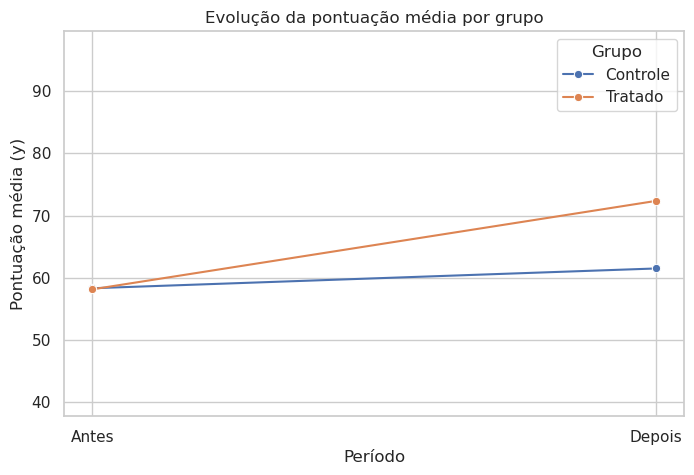

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Número de alunos por grupo
n_alunos = 10
ids_tratado = [f"T{i+1}" for i in range(n_alunos)]
ids_controle = [f"C{i+1}" for i in range(n_alunos)]

# Função para gerar dados
def gerar_linhas(id_list, tratado, efeito_tratamento=0):
    dados = []
    for aluno in id_list:
        y_pre = np.random.normal(60, 10)
        y_pos = y_pre + np.random.normal(5, 5)
        if tratado:
            y_pos += efeito_tratamento
        dados.append([aluno, tratado, 0, y_pre])
        dados.append([aluno, tratado, 1, y_pos])
    return dados

# Gerar e combinar dados
dados_tratado = gerar_linhas(ids_tratado, tratado=1, efeito_tratamento=10)
dados_controle = gerar_linhas(ids_controle, tratado=0)
dados = dados_tratado + dados_controle
df_painel = pd.DataFrame(dados, columns=['ID', 'Tratado', 'Depois', 'y'])

# Criar gráfico de médias
medias = df_painel.groupby(['Tratado', 'Depois'])['y'].mean().reset_index()
medias['Grupo'] = medias['Tratado'].map({0: 'Controle', 1: 'Tratado'})
medias['Período'] = medias['Depois'].map({0: 'Antes', 1: 'Depois'})

# Gráfico
plt.figure(figsize=(8, 5))
sns.lineplot(data=medias, x='Período', y='y', hue='Grupo', marker='o')
plt.title("Evolução da pontuação média por grupo")
plt.ylabel("Pontuação média (y)")
plt.ylim(df_painel['y'].min() - 5, df_painel['y'].max() + 5)
plt.grid(True)
plt.show()


O gráfico acima mostra claramente a **evolução da pontuação média** dos dois grupos ao longo do tempo:

* **Grupo controle**: apresenta uma melhoria moderada entre os períodos “Antes” e “Depois” — isso representa o efeito do tempo (ex: aprendizado natural).
* **Grupo tratado**: apresenta uma **melhoria acentuada** no período “Depois”, o que reflete o efeito combinado do tempo **e da intervenção**.

A distância vertical entre as linhas no período “Depois” **é maior do que no período “Antes”**, o que indica a presença de um **efeito causal diferencial** — exatamente o que a estimativa de Diferença-em-Diferenças captura.

# Técnicas para validação

A validade da abordagem diferença-em-diferenças baseia-se na suposição de **tendências iguais** (*equal trends*). De acordo com essa suposição,  na ausência do programa, não existiriam diferenças variáveis ​​no tempo entre os grupos de tratamento e de controle. Embora esta suposição não possa ser provada, sua validade pode ser validada de quatro maneiras:

1. Comparar repetidamente as mudanças nos resultados dos grupos de tratamento e controle antes de o programa ser implementado. Uu seja, se a intervenção ocorre no tempo $t$, podemos comparar os grupos de tratamento e controle nos tempos $t-3$, $t-2$, $t-1$. Se a tendência dos resultados se mover em paralelo antes do início do programa, provavelmente teria continuado a mover-se em conjunto na ausência do programa.

2. Fazer um teste de placebo usando um grupo de tratamento falso. O grupo de tratamento falso deveria ser um grupo que não foi afetado pelo programa. Um teste placebo que revela impacto zero apoia a suposição de tendência igual.

3. Fazer um teste de placebo usando um resultado falso. Um teste placebo que revela impacto zero apoia a suposição de tendência igual.

4. Executar a estimativa de diferenças em diferenças usando diferentes grupos de comparação. Estimativas semelhantes do impacto do programa confirmam a suposição de tendência igual.